In [0]:
# EVLUATING THE ACCURACY
y_pred = model2.predict(x_test_sequences).argmax(axis=-1)
accuracy = accuracy_score(y_test, y_pred)
f1=f1_score(y_test,y_pred)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

F1 Score: 80.62%
Accuracy: 80.91%


In [0]:
!pip install bert-for-tf2
!pip install sentencepiece

In [0]:
!pip install tensorflow-gpu

In [0]:
!pip install --upgrade grpcio 

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.28.1)


In [0]:
!pip install tensorflow.io

  Using cached https://files.pythonhosted.org/packages/c0/d0/c5d7adce72c6a6d7c9a59c062150f60b5404c706578a0922f7dc2835713c/tensorflow_io-0.12.0-cp36-cp36m-manylinux2010_x86_64.whl


In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',300)

# FOR REMOVING SPECIAL CHARACTERS, LINKS, AND EXPANDING WORDS
import re, unicodedata

# FOR DATA CLEANING, STEMMING AND REMOVNG STOP WORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer   
from nltk.corpus import wordnet
from nltk import pos_tag

# FOR BERT EMBEDDINGS
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

# FOR CNN MODEL
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.layers import concatenate, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

# FOR ATTENTION LAYER
from tensorflow.keras.layers import Attention, Flatten,Activation,Permute,RepeatVector,Lambda,Multiply
from tensorflow.keras.backend import sum as Ksum

# FOR EVALUATION METRICS OF THE PREDICTIONS
from sklearn.metrics import accuracy_score,f1_score

In [0]:
# IMPORTING THE DATASET
train_data=pd.read_csv("TrainingData.csv")
test_data=pd.read_csv("SubtaskA_Trial_Test_Labeled.csv")
valid_data=pd.read_csv("SubtaskA_EvaluationData_labeled.csv")

In [0]:
# PEEKING INTO THE TRAIN DATA
print(train_data.shape)
train_data.head()

(8500, 3)


,id,sentence,label
0,663_3,"""Please enable removing language code from the Dev Center ""language history"" For example if you ever selected ""ru"" and ""ru-ru"" laguages and you published this xap to the Store then it causes Tile localization to show the en-us(default) tile localization which is bad.""",1
1,663_4,"""Note: in your .csproj file, there is a SupportedCultures entry like this: <SupportedCultures>de-DE;ru;ru-RU </SupportedCultures> When I removed the ""ru"" language code and published my new xap version, the old xap version still remains in the Store with ""Replaced and unpublished"".""",0
2,664_1,"""Wich means the new version not fully replaced the old version and this causes me very serious problems: 1.""",0
3,664_2,"""Some of my users will still receive the old xap version of my app.""",0
4,664_3,"""The store randomly gives the old xap or the new xap version of my app.""",0


In [0]:
for x in range(len(train_data['sentence'])):
  print(x,train_data['sentence'][x])

In [0]:
# PEEKING INTO THE VALIDATION DATA
print(valid_data.shape)
valid_data.head()

(833, 3)


,id,sentence,label
0,9566,This would enable live traffic aware apps.,0
1,9569,Please try other formatting like bold italics shadow to distinguish titles/subtitles from content.,1
2,9576,Since computers were invented to save time I suggest we be allowed to upload them all in one zip file - using numbering for the file names and the portal could place them in the right order.,1
3,9577,Allow rearranging if the user wants to change them!,1
4,9579,Add SIMD instructions for better use of ARM NEON instructions for math and games.,1


In [0]:
# PEEKING INTO THE TEST DATA
print(test_data.shape)
test_data.head()

(592, 3)


,id,sentence,label
0,1310_1,"I'm not asking Microsoft to Gives permission like Android so any app can take my data, but don't keep it restricted like iPhone.",1
1,1312_1,somewhere between Android and iPhone.,0
2,1313_1,And in the Windows Store you can flag the App [Requires Trust] for example.,0
3,1313_2,"Many thanks Sameh Hi, As we know, there is a lot of limitations is WP8 OS due the high security in the OS itself which is very good, but some time we need to allow some apps to do extra works, apps which we trust i.e: hotmail app, facebook app, skype app ....",0
4,1313_3,"The idea is that we can develop a regular app and we request our permissions in the manifest, OR the app can ASK FOR TRUST_�_ more",1


In [0]:
y_train = train_data['label']
y_valid = valid_data['label']
y_test = test_data['label']

In [0]:
#####################################################################################
##########################        CLEANING THE DATA        ##########################
#####################################################################################

In [0]:
CONTRACTION_MAP = {"ain't": "is not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","i'd": "i would","i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so as","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have","where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would","you'd've": "you would have","you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have"}

# nltk.download('stopwords')
#### CACHING THE STOP WORDS HELPS IN FASTENING THE REMOVAL OF THE STOP WORDS
# cachedStopWords = stopwords.words("english")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

lemmatizer=WordNetLemmatizer()
corpus_words = set(nltk.corpus.words.words())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
# BERT DOES NOT HANDLES CLEANING ON ITS OWN
def cleanData(data):

    ## REMOVING ASCENTED CHARACTERS LIKE é
    def removeAscentedCharacters(text):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text

    ## EXPANDING THE SHORT WORDS:
    def expandContractions(text, contraction_mapping=CONTRACTION_MAP):
        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())                       
            expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction
            
        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text

    ## REMOVING INVERTED COMMAS
    def removeIC(text):
        if len(text)>=2:
          if text[0]=='"':
            text = text[1:]
          if text[-1]=='"':
            text = text[:-1]
        return text

    # BERTS HANDLES THE STEMMING IN ITS OWN WAY

    def get_simple_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  

    # OUR STEMMING FUNCTION
    def stem(words):
      output_words=[]
      if len(words)!=0:
        words[0] = words[0].lower()
      for w in words:
              pos=pos_tag([w])
              simple_pos = get_simple_pos(pos[0][1])
              clean_word=lemmatizer.lemmatize(w,simple_pos)
              output_words.append(clean_word.lower())
      return output_words

    def stemmizeSentence(sentence):
      output_words = stem(sentence)
      output_wordsf = []
      for i in output_words:
        if i in corpus_words:
          output_wordsf.append(i)
      return output_wordsf

    print('EXPANDING CONTRACTIONS AND REMOVING ASCENTED CHARACTERS...')
    data['clean'] = [removeIC(expandContractions(removeAscentedCharacters(i.lower()))) for i in data['sentence']]

    # print('REMOVING LINKS AND SPECIAL CHARACTERS...')
    data['clean'] = data['clean'].str.replace("(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*"," ")
    data['clean'] = data['clean'].str.replace("\".*?\"|\(.*?\)|<.*>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|[^a-zA-Z#]"," ")

    print("REMOVING DUPLICATE WORDS...")
    data['clean'] = data['clean'].apply(lambda x: re.sub(r'\b(.+)\s+\1\b', r'\1', x))
    
    print('REMOVING STOP WORDS...')
    tokenized_sentence = data['clean'].apply(lambda x: x.split())
    tokenized_sentence = tokenized_sentence.apply(lambda sentence: [word for word in sentence if len(word)>2 ])
    
    # tokenized_sentence = tokenized_sentence.apply( lambda sentence: [word for word in sentence if word not in cachedStopWords] )

    # print('APPLYING STEMMING...')
    # tokenized_sentence = tokenized_sentence.apply(lambda sentence: stemmizeSentence(sentence))
    
    # DETOKENIZING THE TOKENS BACK TO THE SENTENCES
    detokenized= tokenized_sentence.apply(lambda x: ' '.join(x))

    return detokenized

In [0]:
x_train = cleanData(train_data)
print(x_train.shape)
x_train.head()

EXPANDING CONTRACTIONS AND REMOVING ASCENTED CHARACTERS...
REMOVING DUPLICATE WORDS...
REMOVING STOP WORDS...
(8500,)


0    please enable removing language code from the dev center for example you ever selected and laguages and you published this xap the store then causes tile localization show the tile localization which bad
1                                    note your csproj file there supportedcultures entry like this when removed the language code and published new xap version the old xap version still remains the store with
2                                                                                                            wich means the new version not fully replaced the old version and this causes very serious problems
3                                                                                                                                                          some users will still receive the old xap version app
4                                                                                                                                                   the store random

In [0]:
x_valid = cleanData(valid_data)
print(x_valid.shape)
x_valid.head()

EXPANDING CONTRACTIONS AND REMOVING ASCENTED CHARACTERS...
REMOVING DUPLICATE WORDS...
REMOVING STOP WORDS...
(833,)


0                                                                                                                                  this would enable live traffic aware apps
1                                                                             please try other formatting like bold italics shadow distinguish titles subtitles from content
2    since computers were invented save time suggest allowed upload them all one zip file using numbering for the file names and the portal could place them the right order
3                                                                                                                               allow rearranging the user wants change them
4                                                                                              add simd instructions for better use arm neon instructions for math and games
Name: clean, dtype: object

In [0]:
x_test = cleanData(test_data)
print(x_test.shape)
x_test.head()

EXPANDING CONTRACTIONS AND REMOVING ASCENTED CHARACTERS...
REMOVING DUPLICATE WORDS...
REMOVING STOP WORDS...
(592,)


0                                                                                        not asking microsoft gives permission like android any app can take data but not keep restricted like iphone
1                                                                                                                                                                somewhere between android and iphone
2                                                                                                                               and the windows store you can flag the app requires trust for example
3    many thanks sameh know there lot limitations due the high security the itself which very good but some time need allow some apps extra works apps which trust hotmail app facebook app skype app
4                                                                                       the idea that can develop regular app and request our permissions the manifest the app can ask for trust more
Name: clea

In [0]:
mx = max([len(x.split()) for x in x_train])
print(mx) 

147


In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip # BERT BASE MODEL

--2020-04-06 12:11:48--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  84.2MB/s    in 4.9s    

2020-04-06 12:11:53 (79.6 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [0]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
model_dir = "uncased_L-12_H-768_A-12"
bert_model_file = os.path.join(model_dir, "bert_model.ckpt")
bert_config_file = os.path.join(model_dir, "bert_config.json")

In [0]:
tokenizer = FullTokenizer(vocab_file=os.path.join(model_dir, "vocab.txt"))

In [0]:
#####################################################################################
##########################   GENERATING INPUT SEQUENCES   ###########################
#####################################################################################

In [0]:
def generateSequence(sentences,max_seq_len):
  token_id_sequences=[]
  token_list=[]
  for sentence in sentences:
      tokens = tokenizer.tokenize(sentence)
      token_list.append(tokens)
      tokens = ["[CLS]"] + tokens + ["[SEP]"] # TO HELP BERT CONSIDER IT AS A SINGLE SENTENCE
      token_indexes = tokenizer.convert_tokens_to_ids(tokens)
      max_seq_len = max(max_seq_len, len(token_indexes))
      token_id_sequences.append(token_indexes)
  print(token_list)
  return np.array(token_id_sequences),max_seq_len;

In [0]:
max_seq_len=0
train_sequences,max_seq_len = generateSequence(x_train,max_seq_len)
print(train_sequences)
print(max_seq_len)

In [0]:
valid_sequences,max_seq_len = generateSequence(x_valid,max_seq_len)
print(valid_sequences)
print(max_seq_len)

In [0]:
test_sequences,max_seq_len = generateSequence(x_test,max_seq_len)
print(test_sequences)
print(max_seq_len)

In [0]:
print(max_seq_len) # [1400 -> 188] after cleaning!

188


In [0]:
#####################################################################################
##########################       PADDING SEQUENCES        ###########################
#####################################################################################

In [0]:
max_seq_len =  80 
# increasing mxlen does not gurantees higher acc!

In [0]:
def pad(token_id_sequences):
  final_sequences = []
  for input_ids in token_id_sequences:
    input_ids = input_ids[:min(len(input_ids), max_seq_len - 2)]
    input_ids = input_ids + [0] * (max_seq_len - len(input_ids))
    final_sequences.append(np.array(input_ids))
  return np.array(final_sequences)

In [0]:
x_train_sequences = pad(train_sequences)
x_valid_sequences = pad(valid_sequences)
x_test_sequences =  pad(test_sequences)

In [0]:
import pickle
pickle.dump(x_train_sequences,open('x_train_sequences','wb'))
pickle.dump(x_valid_sequences,open('x_valid_sequences','wb'))
pickle.dump(x_test_sequences,open('x_test_sequences','wb'))
pickle.dump(y_train,open('y_train','wb'))
pickle.dump(y_test,open('y_test','wb'))
pickle.dump(y_valid,open('y_valid','wb'))

In [0]:
import pickle
x_train_sequences=pickle.load(open('x_train_sequences','rb'))
x_valid_sequences=pickle.load(open('x_valid_sequences','rb'))
x_test_sequences=pickle.load(open('x_test_sequences','rb'))
y_train=pickle.load(open('y_train','rb'))
y_valid=pickle.load(open('y_valid','rb'))
y_test=pickle.load(open('y_test','rb'))

In [14]:
# print(test_data['sentence'][0])
# print(x_test[0])
print(x_test_sequences[0])

[  101  2025  4851  7513  3957  6656  2066 11924  2151 10439  2064  2202
  2951  2021  2025  2562  7775  2066 18059   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [0]:
#####################################################################################
##########################       BUILDING MODEL           ###########################
#####################################################################################

In [0]:
def BERTCNN_simple_(max_seq_len, bert_model_file):

    # LOADING THE CONFIGURATIONS
    with tensorflow.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
    
    # LAYERS
    sequence_input= Input(shape=(max_seq_len, ), dtype='int32')         # THE SEQUENCE INPUT LAYER 
    bert_layer =    bert(sequence_input)                                # THE BERT LAYER( WITH WEIGHTS)
    lambda_layer=   Lambda(lambda seq: seq[:, 0, :])(bert_layer)        # JUST A RESHAPING LAYER
    
    next_layer =    Dense(256, activation="tanh")(lambda_layer)           # FINAL DENSE LAYER
    next_layer =    Dense(128, activation="tanh")(next_layer)           # FINAL DENSE LAYER
    output_layer =  Dense(2, activation="softmax")(next_layer)          # FINAL OUTPUT LAYER
    # next_layer =    Dropout(0.5)(lambda_layer)                          # DROPOUTS

    # BUILDING AND COMPILING MODEL
    model = Model(sequence_input, output_layer)
    load_stock_weights(bert, bert_model_file)     # LOADING  WEIGHTS

    # the model works well with the softmax layer output and so multilabel
    # it does not trains of simple 1 dense output class
    
    model.compile(
      optimizer=keras.optimizers.Adam(1e-5),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )

    model.summary()
    return model

In [0]:
model1 = BERTCNN_simple_(max_seq_len, bert_model_file)

Done loading 196 BERT weights from: uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f08fa4fa6a0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 80, 768)           108890112 
______________________

In [17]:
history = model1.fit(
  x=x_train_sequences, 
  y=y_train,
  validation_data=(x_valid_sequences, y_valid), 
  batch_size=50,
  shuffle=True,
  epochs=6,
)

Train on 8500 samples, validate on 833 samples
Epoch 1/6
8500/8500 [==============================] - 278s 33ms/sample - loss: 0.3867 - acc: 0.9248 - val_loss: 0.3694 - val_acc: 0.9400
Epoch 2/6
8500/8500 [==============================] - 278s 33ms/sample - loss: 0.3800 - acc: 0.9315 - val_loss: 0.3836 - val_acc: 0.9292
Epoch 3/6
8500/8500 [==============================] - 277s 33ms/sample - loss: 0.3704 - acc: 0.9419 - val_loss: 0.3977 - val_acc: 0.9112
Epoch 4/6
8500/8500 [==============================] - 278s 33ms/sample - loss: 0.3670 - acc: 0.9459 - val_loss: 0.3973 - val_acc: 0.9112
Epoch 5/6
8500/8500 [==============================] - 277s 33ms/sample - loss: 0.3620 - acc: 0.9518 - val_loss: 0.3904 - val_acc: 0.9208
Epoch 6/6
8500/8500 [==============================] - 278s 33ms/sample - loss: 0.3598 - acc: 0.9529 - val_loss: 0.3859 - val_acc: 0.9256


PLOTTING...


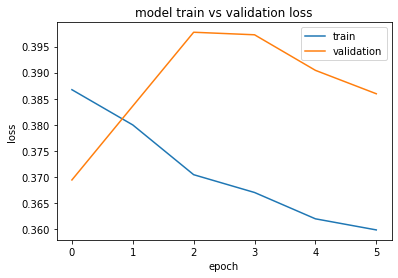

RESULTS..
F1 Score: 81.64%
Accuracy: 82.60%


In [18]:
print('PLOTTING...')
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

print('RESULTS..')

# EVLUATING THE ACCURACY
y_pred = model1.predict(x_test_sequences).argmax(axis=-1)
accuracy = accuracy_score(y_test, y_pred)
f1=f1_score(y_test,y_pred)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [0]:
def BERTCNN_simple_attention(max_seq_len, bert_model_file):

    units=768 # Same as the size of the one hot encoding

    # LOADING THE CONFIGURATIONS
    with tensorflow.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
    
    # LAYERS
    sequence_input= Input(shape=(max_seq_len, ), dtype='int32')         # THE SEQUENCE INPUT LAYER 
    bert_layer =    bert(sequence_input)                                # THE BERT LAYER( WITH WEIGHTS)
    lambda_layer=   Lambda(lambda seq: seq[:, 0, :])(bert_layer)        # JUST A RESHAPING LAYER

    attention = Dense(1, activation='tanh')(lambda_layer)                 # ADDING ATTENTION
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute([2, 1])(attention)
    sent_representation = Multiply()([lambda_layer, attention])
    sent_representation = Lambda(lambda xin: Ksum(xin, axis=-2), output_shape=(units,))(sent_representation)

    next_layer =    Dropout(0.3)(sent_representation)                        # DROPOUTS
    next_layer =    Dense(256, activation="tanh")(next_layer)  # DENSE LAYER
    output_layer =  Dense(2, activation="softmax")(next_layer)          # FINAL OUTPUT LAYER

    # the model works well with the softmax layer output and so multilabel
    # it does not trains of simple 1 dense output class

    # BUILDING AND COMPILING MODEL
    model = Model(sequence_input, output_layer)
    load_stock_weights(bert, bert_model_file)     # LOADING  WEIGHTS
    
    model.compile(
      optimizer=keras.optimizers.Adam(1e-5),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )

    model.summary()
    return model

In [31]:
model2 = BERTCNN_simple_attention(max_seq_len, bert_model_file)

Done loading 196 BERT weights from: uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f08cbb10438> (prefix:bert_6). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 80)]         0                                            
___________________________________________________

In [34]:
history = model2.fit(
  x=x_train_sequences, 
  y=y_train,
  validation_data=(x_valid_sequences, y_valid), 
  batch_size=50,
  shuffle=True,
  epochs=8,
)

Train on 8500 samples, validate on 833 samples
Epoch 1/8
8500/8500 [==============================] - 279s 33ms/sample - loss: 0.4170 - acc: 0.8932 - val_loss: 0.3896 - val_acc: 0.9208
Epoch 2/8
8500/8500 [==============================] - 279s 33ms/sample - loss: 0.3990 - acc: 0.9111 - val_loss: 0.3792 - val_acc: 0.9340
Epoch 3/8
8500/8500 [==============================] - 279s 33ms/sample - loss: 0.3894 - acc: 0.9229 - val_loss: 0.3843 - val_acc: 0.9268
Epoch 4/8
8500/8500 [==============================] - 279s 33ms/sample - loss: 0.3806 - acc: 0.9309 - val_loss: 0.3932 - val_acc: 0.9172
Epoch 5/8
8500/8500 [==============================] - 279s 33ms/sample - loss: 0.3730 - acc: 0.9382 - val_loss: 0.3820 - val_acc: 0.9304
Epoch 6/8
8500/8500 [==============================] - 279s 33ms/sample - loss: 0.3669 - acc: 0.9460 - val_loss: 0.3961 - val_acc: 0.9148
Epoch 7/8
8500/8500 [==============================] - 279s 33ms/sample - loss: 0.3657 - acc: 0.9473 - val_loss: 0.3997 - val

PLOTTING...


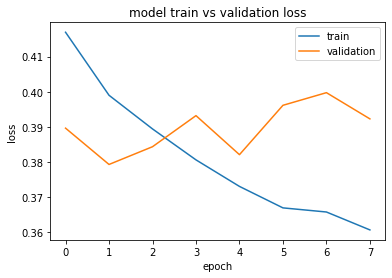

RESULTS..
F1 Score: 80.62%
Accuracy: 80.91%


In [37]:
print('PLOTTING...')
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
print('RESULTS..')

# EVLUATING THE ACCURACY
y_pred = model2.predict(x_test_sequences).argmax(axis=-1)
accuracy = accuracy_score(y_test, y_pred)
f1=f1_score(y_test,y_pred)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))